# Modelling

First thing is the load all the libaries...

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_curve, roc_auc_score
import warnings
warnings.filterwarnings("ignore")

... and the most important part, the data!

In [2]:
data = pd.read_csv('../data/preprocessed_data.csv', index_col=0)

In [3]:
X = data.copy()
X.drop(['Attrition'], axis=1, inplace=True)
y = data['Attrition']

In [4]:
X_train = pd.read_csv('../data/X_train.csv', index_col=0)
y_train = pd.read_csv('../data/y_train.csv', index_col=0)['Attrition']
X_test = pd.read_csv('../data/X_test.csv', index_col=0)
y_test = pd.read_csv('../data/y_test.csv', index_col=0)['Attrition']

## Model Selection

I am going to go through a baseline models and 4 actual models: KNN, Decision Tree, Random Forest and Gradrient Boosting. I will also do a 5 fold cross validation using a Randomized Search.

### Dummy Classifier

I'll start off with a baseline model using the `DummyClassifier`. 

In [5]:
dummy = DummyClassifier(strategy='stratified')

In [6]:
dummy.fit(X_train, y_train)

DummyClassifier(strategy='stratified')

In [7]:
y_predict_dummy = dummy.predict(X_test)

In [8]:
dummy_report = classification_report(y_test, y_predict_dummy)
print(dummy_report)

              precision    recall  f1-score   support

           0       0.47      0.46      0.47       370
           1       0.47      0.49      0.48       370

    accuracy                           0.47       740
   macro avg       0.47      0.47      0.47       740
weighted avg       0.47      0.47      0.47       740



Results are just as I expected. I dealt with the data imbalance in the preprocessing phase, so these scores make a lot of sense. This shouldn't be hard to beat.

### KNN

In [9]:
knn = KNeighborsClassifier()

In [10]:
algorithm = ['brute', 'ball_tree', 'kd_tree']
n_neighbors = [i*2 for i in range(1,50)]
weights = ['distance', 'uniform']
param_dist = {"n_neighbors": n_neighbors, "weights": weights, "algorithm": algorithm}

In [11]:
rand_search = RandomizedSearchCV(estimator=knn, param_distributions=param_dist, 
                                 cv=10, random_state=1)
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(),
                   param_distributions={'algorithm': ['brute', 'ball_tree',
                                                      'kd_tree'],
                                        'n_neighbors': [2, 4, 6, 8, 10, 12, 14,
                                                        16, 18, 20, 22, 24, 26,
                                                        28, 30, 32, 34, 36, 38,
                                                        40, 42, 44, 46, 48, 50,
                                                        52, 54, 56, 58, 60, ...],
                                        'weights': ['distance', 'uniform']},
                   random_state=1)

In [12]:
best_knn = rand_search.best_estimator_

In [13]:
print(best_knn)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=14, weights='distance')


In [14]:
knn = best_knn
knn.fit(X_train, y_train)
y_predict_knn = knn.predict(X_test)

In [15]:
knn_report = classification_report(y_test, y_predict_knn)
print(knn_report)

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       370
           1       0.85      0.91      0.88       370

    accuracy                           0.88       740
   macro avg       0.88      0.88      0.88       740
weighted avg       0.88      0.88      0.88       740



The f1 scores are pretty good. So is the accuracy. This is a good start. 

### Decision Tree

In [16]:
dt = DecisionTreeClassifier()

In [17]:
criterion = ['gini', 'entropy']
splitter = ['random', 'best']
max_depth = [i for i in range(2, 20)]
min_samples_split = [i for i in range (2, 5)]
max_features = [i for i in range(1, 40)]

In [18]:
param_dist = {"criterion" : criterion, 
              "splitter" : splitter, 
              "max_depth" : max_depth,
              "min_samples_split": min_samples_split,
              "max_features": max_features}

In [19]:
rand_search = RandomizedSearchCV(dt, param_distributions=param_dist, 
                                 cv=10, random_state=1)

In [20]:
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19, 20,
                                                         21, 22, 23, 24, 25, 26,
                                                         27, 28, 29, 30, ...],
                                        'min_samples_split': [2, 3, 4],
                                        'splitter': ['random', 'best']},
                   random_state=1)

In [21]:
best_dt = rand_search.best_estimator_

In [22]:
best_dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=17, max_features=16)

In [23]:
y_predict_dt = best_dt.predict(X_test)

In [24]:
dt_report = classification_report(y_test, y_predict_dt)
print(dt_report)

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       370
           1       0.82      0.84      0.83       370

    accuracy                           0.82       740
   macro avg       0.82      0.82      0.82       740
weighted avg       0.82      0.82      0.82       740



This is worse than the KNN model. This rules out the Decision Tree. 

### Random Forest

In [25]:
rf = RandomForestClassifier()

In [26]:
criterion = ['gini', 'entropy']
max_depth = [i*2 for i in range(2, 10)]
min_samples_split = [i*2 for i in range (1, 20)]
max_features = ['auto', 'sqrt', 'log2'] + [i for i in range(1, 40)]
bootstrap = [True, False]
n_estimators = [i*10 for i in range(1,10)]

In [27]:
param_dist = {"criterion": criterion,
              "n_estimators": n_estimators,
              "max_depth": max_depth,
              "max_features": max_features,
              "bootstrap": bootstrap,
              "max_features": max_features}

In [28]:
rand_search = RandomizedSearchCV(rf, param_distributions=param_dist, scoring='f1', 
                                 cv=10, random_state=1)

In [29]:
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 6, 8, 10, 12, 14, 16,
                                                      18],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19, 20,
                                                         21, 22, 23, 24, 25, 26,
                                                         27, ...],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90]},
                   random_state=1, 

In [30]:
best_rf = rand_search.best_estimator_

In [31]:
best_rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=14, max_features=13,
                       n_estimators=80)

In [32]:
y_predict_rf = best_rf.predict(X_test)

In [33]:
rf_report = classification_report(y_test, y_predict_rf)
print(rf_report)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       370
           1       0.92      0.90      0.91       370

    accuracy                           0.91       740
   macro avg       0.91      0.91      0.91       740
weighted avg       0.91      0.91      0.91       740



This is slightly better than the KNN model, but not by much.

### Logistic Regression

In [34]:
lr = LogisticRegression()

In [35]:
penalty = ['l1', 'l2', 'elasticnet', 'none']
dual = [True, False]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
l1_ratio = [i/10 for i in range(0, 10)]

In [36]:
param_dist = {"penalty": penalty,
              "dual": dual,
              "solver": solver,
              "l1_ratio": l1_ratio}

In [37]:
rand_search = RandomizedSearchCV(lr, param_distributions=param_dist, scoring='f1', 
                                 cv=10, random_state=1)

In [38]:
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=LogisticRegression(),
                   param_distributions={'dual': [True, False],
                                        'l1_ratio': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                     0.5, 0.6, 0.7, 0.8, 0.9],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=1, scoring='f1')

In [39]:
best_lr = rand_search.best_estimator_
print(rand_search.best_estimator_)

LogisticRegression(l1_ratio=0.6, penalty='none', solver='saga')


In [40]:
y_predict_lr = best_lr.predict(X_test)

In [41]:
lr_report = classification_report(y_test, y_predict_lr)
print(lr_report)

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       370
           1       0.94      0.88      0.91       370

    accuracy                           0.91       740
   macro avg       0.92      0.91      0.91       740
weighted avg       0.92      0.91      0.91       740



### Gradient Boosting

In [42]:
gb = GradientBoostingClassifier()

In [43]:
loss = ['deviance', 'exponential']
n_estimators = [i*10 for i in range(1,20)]
criterion = ['friedman_mse', 'mse', 'mae']
min_samples_split = [i*2 for i in range (1, 21)]
max_depth = [i*2 for i in range(2, 10)]
max_features = [i for i in range(1, 40)]

In [44]:
param_dist = {"loss": loss,
              "n_estimators": n_estimators,
              "criterion": criterion,
              "min_samples_split": min_samples_split,
              "max_depth": max_depth,
              "max_features": max_features
              }

In [45]:
rand_search = RandomizedSearchCV(gb, param_distributions=param_dist, scoring='f1', 
                                 cv=10, random_state=1)

In [46]:
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(),
                   param_distributions={'criterion': ['friedman_mse', 'mse',
                                                      'mae'],
                                        'loss': ['deviance', 'exponential'],
                                        'max_depth': [4, 6, 8, 10, 12, 14, 16,
                                                      18],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19, 20,
                                                         21, 22, 23, 24, 25, 26,
                                                         27, 28, 29, 30, ...],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              12, 14, 16, 18,
                      

In [47]:
best_gb = rand_search.best_estimator_
print(rand_search.best_estimator_)

GradientBoostingClassifier(criterion='mse', loss='exponential', max_depth=18,
                           max_features=31, min_samples_split=12)


In [48]:
y_predict_gb = best_gb.predict(X_test)

In [49]:
gb_report = classification_report(y_test, y_predict_gb)
print(gb_report)

              precision    recall  f1-score   support

           0       0.90      0.93      0.92       370
           1       0.93      0.90      0.91       370

    accuracy                           0.91       740
   macro avg       0.92      0.91      0.91       740
weighted avg       0.92      0.91      0.91       740



Gradient boosting is the best performing model thus far. 

## Feature Importance

In [50]:
features = X
importances = np.sort(list(best_gb.feature_importances_))

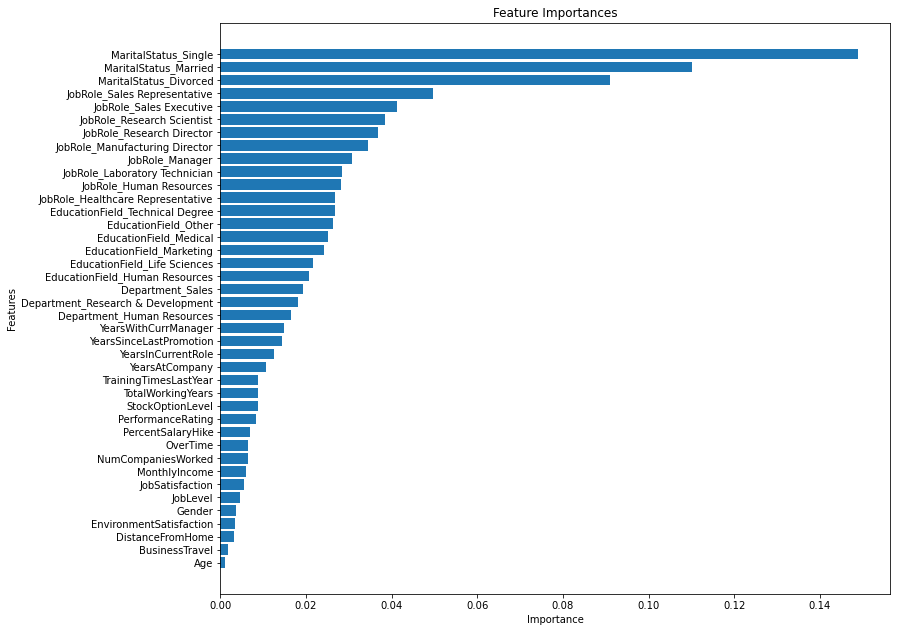

In [51]:
plt.figure(figsize=(12, 10.5))
plt.barh([i for i in range(0, 40)], importances)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.yticks([i for i in range(0, 40)], features)
plt.title('Feature Importances')
plt.show()

Looks like the most important features all have to do with marital status. People's outside life seems to impact their have an impact at work. 

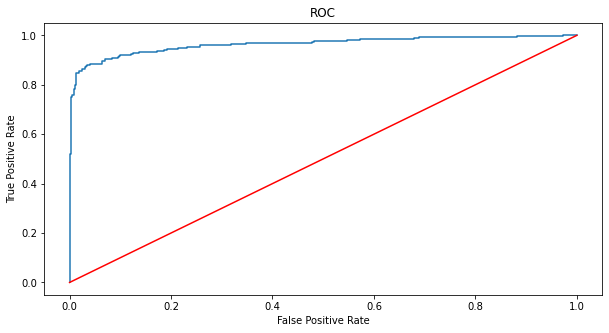

In [52]:
y_scores_gb = best_gb.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores_gb)
plt.figure(figsize=(10, 5))
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1], 'r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()